In [1]:
import os
import sys
import glob
import pickle
import tables

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from comet_ml.api import API, APIExperiment
from comet_ml.query import Tag

if '..' not in sys.path:
    sys.path.append('..')
from deep_utils import *

#### Find the best experiment given a set of tags

In [2]:
api = API(api_key = os.environ['COMET_API_KEY'])
workspace = 'danielelinaro'
project_name = 'inertia'
generator_ID = 1
D = 2
DZA = 60
# activation = 'ReLU_after_pooling'
query = Tag('IEEE14') & \
        Tag(f'G{generator_ID}') & \
        Tag(f'D={D}') & \
        Tag(f'DZA={DZA}') & \
        Tag('1D_pipeline') #& Tag(activation)
experiments = api.query(workspace, project_name, query, archived=False)
experiment_IDs = []
MAPE = []
val_loss = []
tags =  []
for experiment in experiments:
    ID = experiment.id
    experiment_IDs.append(ID)
    sys.stdout.write(f'Downloading data for experiment ID {ID}... ')
    metrics = experiment.get_metrics()
    sys.stdout.write('done.\n')
    val_loss.append(np.array([float(m['metricValue']) for m in metrics if m['metricName'] == 'val_loss']))
    MAPE.append([float(m['metricValue']) for m in metrics if m['metricName'] == 'mape_prediction'][0])
    tags.append(experiment.get_tags())
    print(f'  val_loss: {val_loss[-1].min():.4f}')
    print(f'      MAPE: {MAPE[-1]:.2f}%')
    print('      Tags: "{}"'.format('" "'.join(tags[-1])))
# idx = np.argmin(MAPE)
idx = np.argmin([loss.min() for loss in val_loss])
experiment_ID = experiment_IDs[idx]
MAPE = MAPE[idx]
val_loss = val_loss[idx]
tags = tags[idx]
print(f'The best experiment is {experiment_ID[:6]} (val_loss = {val_loss.min():.4f}, MAPE = {MAPE:.2f}%).')

  val_loss: 0.0247
      MAPE: 0.54%
      Tags: "1D_pipeline" "D=2" "DZA=60" "G1" "IEEE14" "ReLU_none"
  val_loss: 0.0262
      MAPE: 0.65%
      Tags: "1D_pipeline" "D=2" "DZA=60" "G1" "IEEE14" "ReLU_after_pooling"
  val_loss: 0.0236
      MAPE: 0.50%
      Tags: "1D_pipeline" "D=2" "DZA=60" "G1" "IEEE14" "ReLU_after_conv"
The best experiment is 2bfabe (val_loss = 0.0236, MAPE = 0.50%).


In [5]:
experiments_path = '../experiments/neural_network/'
checkpoint_path = experiments_path + experiment_ID + '/checkpoints/'
checkpoint_files = glob.glob(checkpoint_path + '*.h5')
network_parameters = pickle.load(open(experiments_path + experiment_ID \
                                      + '/parameters.pkl', 'rb'))
epochs = [int(os.path.split(file)[-1].split('.')[1].split('-')[0]) for file in checkpoint_files]
best_checkpoint = checkpoint_files[epochs.index(np.argmin(val_loss) + 1)]
model = keras.models.load_model(best_checkpoint, compile=True)
data_dir = '../' + network_parameters['data_dir']
# we need mean and standard deviation of the training set to normalize the data
x_train_mean = network_parameters['x_train_mean']
x_train_std  = network_parameters['x_train_std']
if not os.path.isdir(data_dir):
    path = ''
    for d in data_dir.split(os.path.sep):
        path += d + os.path.sep
        if d == 'data':
            path += f'IEEE14/var_H_G{generator_ID}/'
    data_dir = path
print('Loaded network from {}.'.format(best_checkpoint))
print('Data directory is {}.'.format(data_dir))

Loaded network from ../experiments/neural_network/2bfabe9a6a7d46c389fec10fb198bfed/checkpoints/weights.960-0.02.h5.
Data directory is ../data/IEEE14/var_H_G1/IEEE14_D=2_DZA=60.0/.


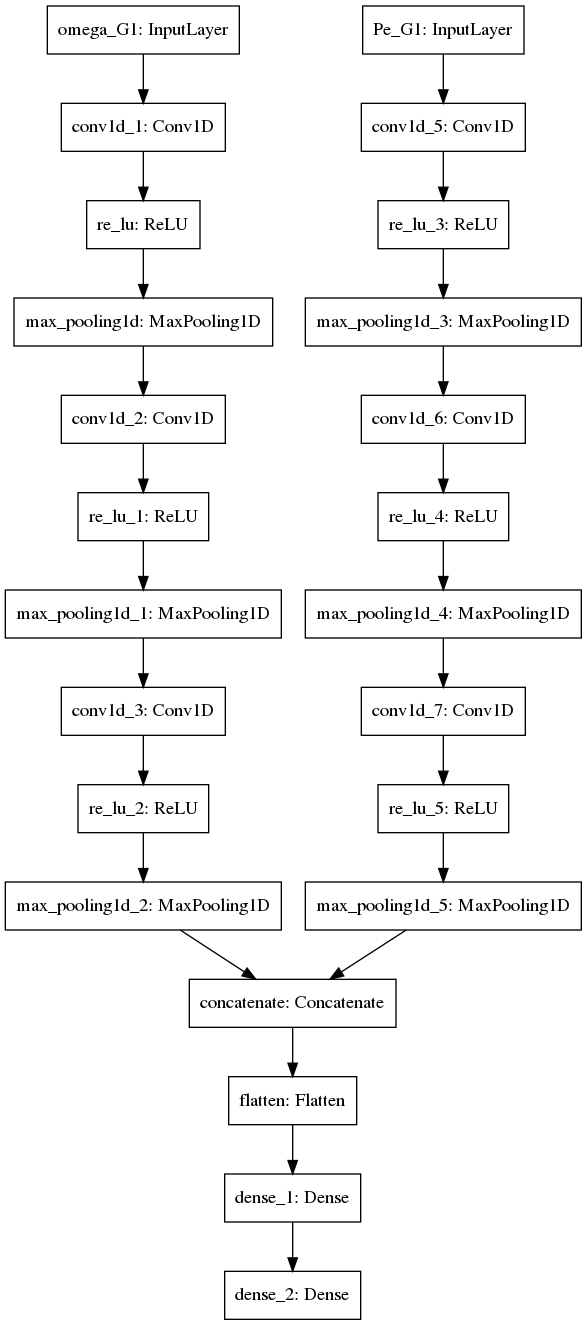

In [6]:
keras.utils.plot_model(model, show_shapes=False, dpi=96)

### Constant inertia
Estimation of the value of inertia for all the generators in the IEEE14 network. The neural network has been trained using data from one generator.

In [7]:
generator_IDs = (1, 2, 3, 6, 8)
window_dur = 60
window_step = 10
H_value = 8.5
data_file = f'{data_dir}/H_{H_value:.3f}.h5'
estimate_mean_std = False
time = {}
inertia = {}
data = {}
data_normalized = {}
data_sliding = {}
for gen_id in generator_IDs:
    var_names = [f'omega_G{gen_id}', f'Pe_G{gen_id}']
    data_mean, data_std = None, None
    if not estimate_mean_std and gen_id == generator_ID:
        data_mean = {var_name: x_train_mean[i] for i,var_name in enumerate(var_names)}
        data_std = {var_name: x_train_std[i] for i,var_name in enumerate(var_names)}
    else:
        data_mean = None
        data_std = None
    t, data[gen_id], data_normalized[gen_id], data_sliding, _ = load_data_slide([data_file],
                                                                                var_names,
                                                                                data_mean,
                                                                                data_std,
                                                                                window_dur,
                                                                                window_step,
                                                                                verbose=True)
    data_sliding[f'omega_G{generator_ID}'] = data_sliding.pop(f'omega_G{gen_id}')
    data_sliding[f'Pe_G{generator_ID}'] = data_sliding.pop(f'Pe_G{gen_id}')
    dt = np.diff(t[:2])[0]
    time, inertia[gen_id], _ = predict(model, data_sliding, window_step, dt)

Window size: 600 samples
Number of trials: 3540
data_mean = {'omega_G2': 0.9999910095216009, 'Pe_G2': 40001057.04207428}
data_std = {'omega_G2': 0.00015034691199594866, 'Pe_G2': 42758.99983997918}
Window size: 600 samples
Number of trials: 3540
data_mean = {'omega_G3': 0.9999910094085612, 'Pe_G3': 1066.7621484237452}
data_std = {'omega_G3': 0.00015036588057684813, 'Pe_G3': 43596.838645435535}
Window size: 600 samples
Number of trials: 3540
data_mean = {'omega_G6': 0.9999910099024883, 'Pe_G6': 397.3478543693881}
data_std = {'omega_G6': 0.00015012893877817572, 'Pe_G6': 29367.082238293482}
Window size: 600 samples
Number of trials: 3540
data_mean = {'omega_G8': 0.9999910093838891, 'Pe_G8': 431.0613999155772}
data_std = {'omega_G8': 0.00015021741927228642, 'Pe_G8': 21745.391692473928}
Window size: 600 samples
Number of trials: 3540


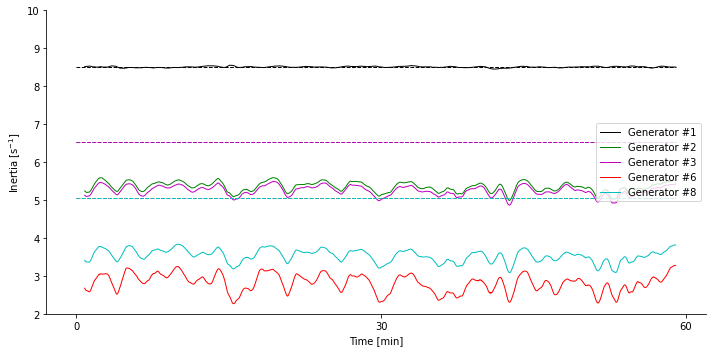

In [8]:
default_H = {
    1: 10.296 / 2,
    2: 13.08 / 2,
    3: 13.08 / 2,
    6: 10.12 / 2,
    8: 10.12 / 2
}
default_H[generator_ID] = H_value
cmap = 'kgmrc'
fig,ax = plt.subplots(1, 1, figsize=[10,5])
for gen_id,col in zip(generator_IDs, cmap):
    ax.plot(time[[0,-1]] / 60, default_H[gen_id] + np.zeros(2), col + '--', lw=1)
    ax.plot(time / 60, inertia[gen_id], col, lw=1, label=f'Generator #{gen_id}')
ax.legend(loc='center right')
ax.set_xlabel('Time [min]')
ax.set_ylabel(r'Inertia [s$^{-1}$]')
ax.set_xticks(np.arange(time[0], time[-1]/60+10, 30))
for side in 'right', 'top':
    ax.spines[side].set_visible(False)
ax.set_ylim([2,10])
fig.tight_layout()

### Step of inertia
1. H steps **instantaneously** from 3.5 to 3.8
1. **omega** and **Pe** of the first generator used for the estimation
1. two simulations joined together (i.e., **no transient** during the step)

In [10]:
window_dur = 60
window_step = 10
H_values = [3.5, 8.5]
data_files = [f'{data_dir}/H_{h:.3f}.h5' for h in H_values]
gen_id = 1
var_names = [f'omega_G{gen_id}', f'Pe_G{gen_id}']
if gen_id == generator_ID:
    data_mean = {var_name: x_train_mean[i] for i,var_name in enumerate(var_names)}
    data_std = {var_name: x_train_std[i] for i,var_name in enumerate(var_names)}
else:
    data_mean = None
    data_std = None
t, data, data_normalized, data_sliding, _ = load_data_slide(data_files,
                                                            var_names,
                                                            data_mean,
                                                            data_std,
                                                            window_dur,
                                                            window_step,
                                                            verbose=True)
if gen_id != generator_ID:
    data_sliding[f'omega_G{generator_ID}'] = data_sliding.pop(f'omega_G{gen_id}')
    data_sliding[f'Pe_G{generator_ID}'] = data_sliding.pop(f'Pe_G{gen_id}')
dt = np.diff(t[:2])[0]
time, H, _ = predict(model, data_sliding, window_step, dt)

Window size: 600 samples
Number of trials: 7140


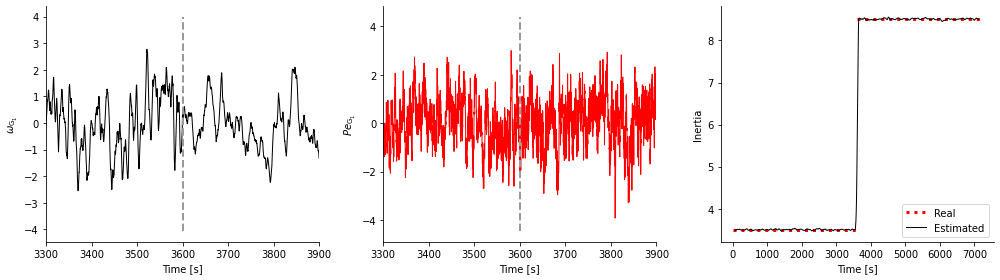

In [11]:
fig,ax = plt.subplots(1, 3, figsize=(14,4))
ax[0].plot(t, data_normalized[var_names[0]], 'k', lw=1)
ax[0].plot([3600, 3600], ax[0].get_ylim(), '--', lw=2, color=[.6,.6,.6])
ax[1].plot(t, data_normalized[var_names[1]], 'r', lw=1)
ax[1].plot([3600, 3600], ax[0].get_ylim(), '--', lw=2, color=[.6,.6,.6])
if gen_id == generator_ID:
    ax[2].plot([0, 3600], H_values[0] + np.zeros(2), 'r:', lw=3)
    ax[2].plot([3600, 7200], H_values[1] + np.zeros(2), 'r:', lw=3, label='Real')
else:
    ax[2].plot([0, 7200], default_H[gen_id] + np.zeros(2), 'r:', lw=2, label='Real')
ax[2].plot(time, H, 'k', lw=1, label='Estimated')

ax[2].legend(loc='lower right')
ax[0].set_ylabel(r'$\omega_{\mathrm{G}_1}$')
ax[1].set_ylabel(r'$Pe_{\mathrm{G}_1}$')
ax[2].set_ylabel('Inertia')
for a in ax:
    a.set_xlabel('Time [s]')
    if a != ax[2]:
        a.set_xlim([3300, 3900])
    for side in 'right','top':
        a.spines[side].set_visible(False)

fig.tight_layout()

### Ramp of inertia
H increases **gradually** from 3.5 to 6.5 in 100 seconds (from t = 3550s to t=3650s)